# U2Net Implementation

Try to implement U2Net for Background Removal and Bounding Box Creation.

In [1]:
import sys
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [2]:
%cd /content

#Cloning the repository on GitHub
!git clone https://github.com/shreyas-bk/U-2-Net

%cd /content/U-2-Net

print('Making Original Image directory: ')
!mkdir images

print('Making Results Image directory: ')
!mkdir results

/content
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 520 (delta 237), reused 510 (delta 236), pack-reused 0
Receiving objects: 100% (520/520), 12.38 MiB | 8.46 MiB/s, done.
Resolving deltas: 100% (237/237), done.
/content/U-2-Net
Making Original Image directory: 
Making Results Image directory: 


Importing the Required Libraries

In [10]:
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image
import cv2
import requests
from io import BytesIO
from skimage.transform import resize
import matplotlib.pyplot as plt
print("Imports Done!")

Imports Done!


In [4]:
#Get the Image from the Internet and store the name
img_url = 'https://ichef.bbci.co.uk/news/976/cpsprodpb/0635/production/_92798510_afp_gomez.jpg'
img_name = img_url.split('/')[-1]
img_name

'_92798510_afp_gomez.jpg'

In [5]:
%cd /content/U-2-Net/images

img = Image.open(BytesIO(requests.get(img_url).content))
curr_dir = os.getcwd()

img.save(curr_dir+'/'+img_name,format='JPEG')
print('Image Saved!')

%cd /content/U-2-Net

/content/U-2-Net/images
Image Saved!
/content/U-2-Net


In [6]:
# run the test script, and outputs are saved to results folder
!python -W ignore u2net_test.py

['/content/U-2-Net/images/_92798510_afp_gomez.jpg']
inferencing: _92798510_afp_gomez.jpg


In [7]:
#get the names of the images that were uploaded, removing .jpg
image_dir = os.path.join(os.getcwd(), 'images')
names = []
for name in os.listdir(image_dir):
  names.append(name[:-4])

name = names[0]
name

'_92798510_afp_gomez'

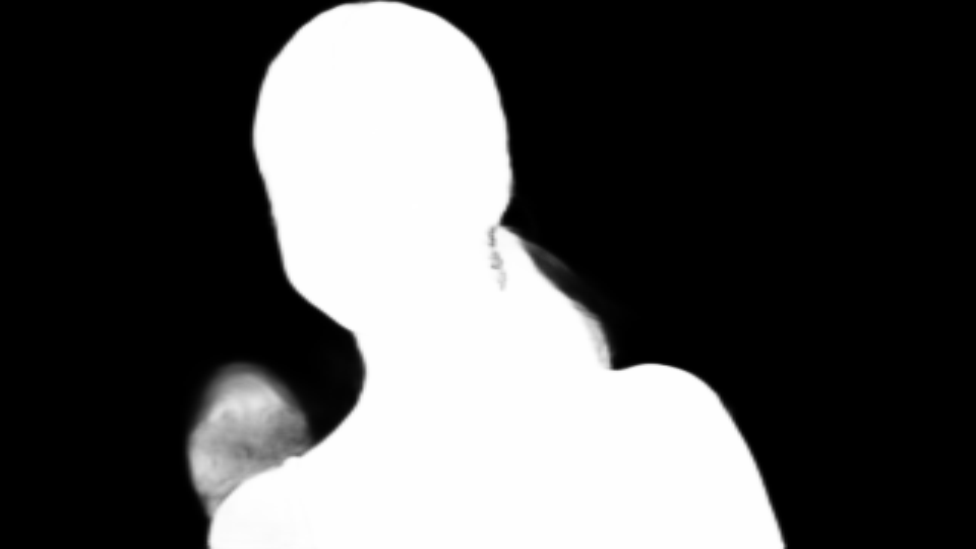

In [9]:
#Display the result that was created using U2Net
output = load_img('/content/U-2-Net/results/'+name+'.png')
output

Removing the Background with the Help of the Mask Created

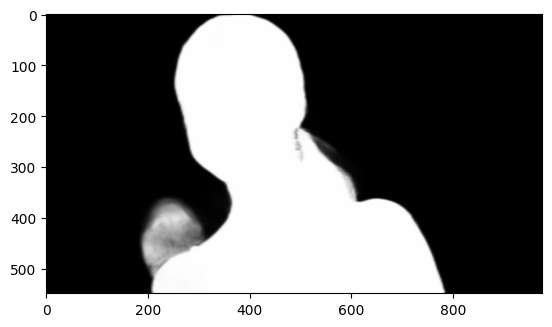

In [11]:
#Convert the output to a Numpy Array and rescale it
RESCALE = 255
out_img = img_to_array(output)
out_img /= RESCALE
plt.imshow(out_img)

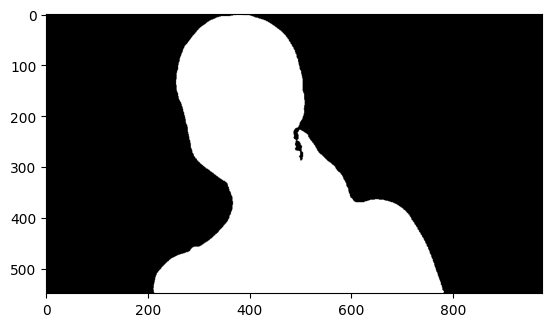

In [12]:
#define an experimental threshold for which background is removed
THRESHOLD = 0.9

#Now we will refine the mask with the help of the threshold
out_img[out_img > THRESHOLD] = 1
out_img[out_img < THRESHOLD] = 0
plt.imshow(out_img)

In [13]:
#According the U2Net Paper, we need to convert the rgb image to rgba and set the zero values to transparent
shape = out_img.shape
print(shape)

(549, 976, 3)


In [17]:
init_layer = np.ones(shape = (shape[0],shape[1],1))
print(init_layer.shape)

(549, 976, 1)


In [19]:
mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
print("Mul Layer Dimensions: ",mul_layer.shape)
a_layer = mul_layer * init_layer
print(a_layer.shape)

Mul Layer Dimensions:  (549, 976, 1)
(549, 976, 1)


In [24]:
rgba_out = np.append(out_img,a_layer,axis=2)
print(rgba_out.shape)

(549, 976, 4)


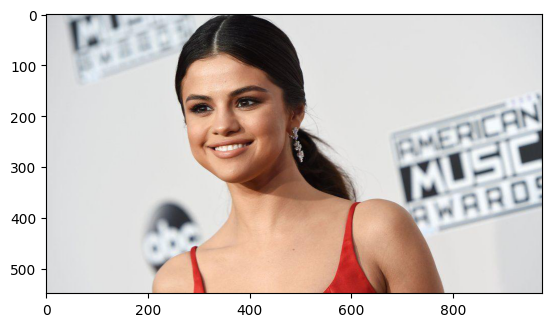

In [23]:
#Load and convert the input to the numpy array and rescale it
input = load_img('/content/U-2-Net/images/'+img_name)
inp_img = img_to_array(input)
inp_img /= RESCALE
plt.imshow(inp_img)

(549, 976, 4)


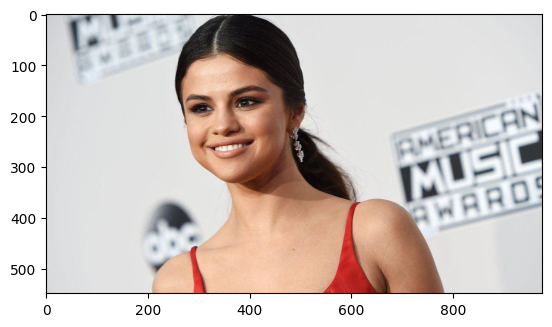

In [25]:
#convert this to rgba as well
a_layer = np.ones(shape = (shape[0],shape[1],1))
rgba_inp = np.append(inp_img,a_layer,axis=2)
plt.imshow(rgba_inp)
print(rgba_inp.shape)

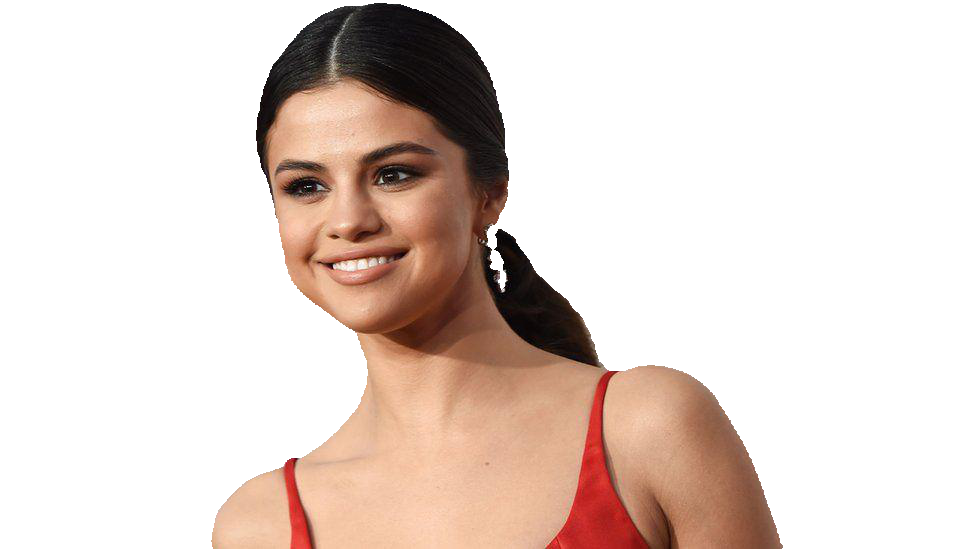

In [26]:
#Acc to the U2Net Model, we need to multiply the 2 rgba images to remove the background
rem_back = (rgba_inp * rgba_out)
rem_back_scaled = Image.fromarray((rem_back*RESCALE).astype('uint8'),'RGBA')
display(rem_back_scaled)

In [28]:
#Saving it in results folder
rem_back_scaled.save('/content/U-2-Net/results/'+name+'_background_removed.png')

Creating a Bounding Box upon the given image

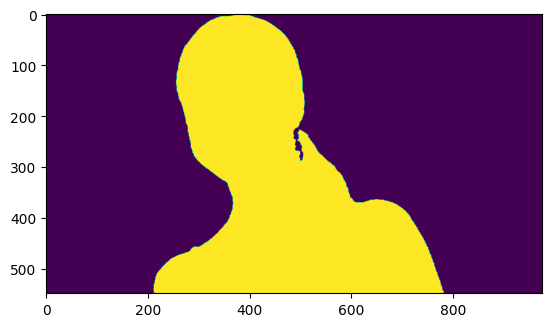

In [31]:
#We have to select a layer for the bounding box creation (Any of the R or G or B layers)
LAYER = 1
out_layer = out_img[:,:,LAYER]
plt.imshow(out_layer)

In [37]:
#Figure out the x and y values where the saliency starts:
x_starts = []
x_ends = []
for i in range(out_layer.shape[0]):
  if len(np.where(out_layer[i]==1)[0])!=0:
    x_starts.append(np.where(out_layer[i] == 1)[0][0])
    x_ends.append(np.where(out_layer[i] == 1)[0][-1])
  else:
    x_starts.append(out_layer.shape[0]+1)
    x_ends.append(0)

In [38]:
y_starts = []
y_ends = []
for i in range(out_layer.T.shape[0]):
  if len(np.where(out_layer.T[i]==1)[0])!=0:
    y_starts.append(np.where(out_layer.T[i] == 1)[0][0])
    y_ends.append(np.where(out_layer.T[i] == 1)[0][-1])
  else:
    y_starts.append(out_layer.T.shape[0]+1)
    y_ends.append(0)

In [40]:
#Get the starting and ending coordinated for the box
startx = min(x_starts)
endx = max(x_ends)
starty = min(y_starts)
endy = max(y_ends)

start = (startx,starty)
end = (endx,endy)
start,end

((211, 3), (782, 548))

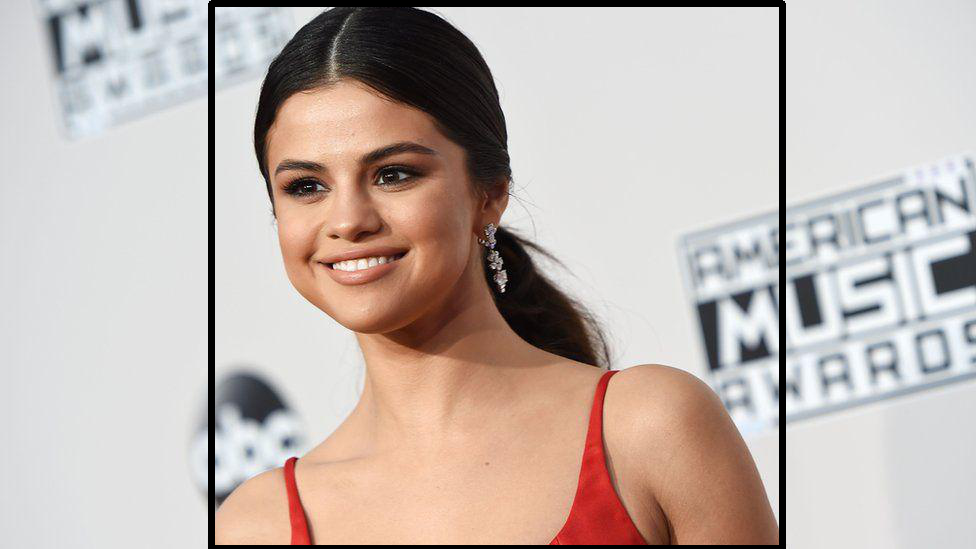

In [42]:
#Using cv2 to create the bounding box
COLOR = (0,0,0)
THICKNESS = 5
box_img = inp_img.copy()
box_img *= RESCALE
box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
box_img_scaled = Image.fromarray(box_img.astype('uint8'),'RGB')
display(box_img_scaled)

In [43]:
box_img_scaled.save('/content/U-2-Net/results/'+name+'_bounding_box.png')

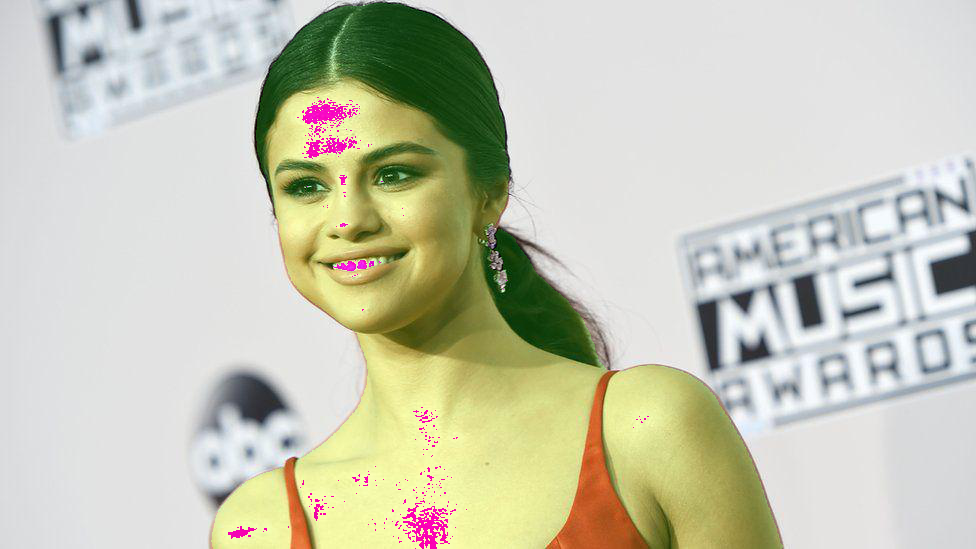

In [51]:
#Set the salient shift value and add it to a layer of the Input image
SAL_SHIFT = 50
sal_img = inp_img.copy()
sal_img *= RESCALE
add_layer = out_img.copy()
add_layer[add_layer == 1] = SAL_SHIFT
sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
sal_img_scaled = Image.fromarray(sal_img.astype('uint8'),'RGB')
display(sal_img_scaled)

In [52]:
sal_img_scaled.save('/content/U-2-Net/results/'+name+'_salientMap.png')